# Two_model_TextCNN_&_BiGRU

## 1、initial preparation work

### import related packages

In [43]:
# import related packages
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.layers.merge import concatenate
from keras.models import  Model
from keras.layers import Dense, Embedding, Input,PReLU,add,Bidirectional
from keras.layers import Convolution1D, Flatten, Dropout,MaxPooling1D,GlobalMaxPooling1D,GRU,SpatialDropout1D,Conv1D
from keras.layers import BatchNormalization
from keras.utils.np_utils import to_categorical
from itertools import cycle
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,label_binarize
from gensim.models import word2vec
import pickle
from gensim.models import KeyedVectors
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping,ModelCheckpoint
from sklearn.model_selection import KFold,StratifiedKFold
import keras.backend.tensorflow_backend as KTF
import tensorflow as tf
from sklearn.metrics import recall_score,precision_score,roc_curve, auc
import os
from scipy import interp

### USING GPU OR NOT

In [2]:
# If you need to use a GPU, execute the following code
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
# Not fully occupied by video memory, allocated on demand
sess = tf.Session(config=config)
KTF.set_session(sess)

### Setting related parameters

In [3]:
# define max_sequence length、max_num_words、embedding_dim
MAX_SEQUENCE_LENGTH = 110
MAX_NB_WORDS = 20000
EMBEDDING_DIM = 100

In [4]:
# DPCNN parameters
filter_nr = 64
filter_size = 3
max_pool_size = 3
max_pool_strides = 2
dense_nr = 256
spatial_dropout = 0.2
dense_dropout = 0.5
train_embed = False

### Read data

In [5]:
# read dataset and set header names
data = pd.read_csv('./data/data.csv')

In [6]:
# view top5 data
data.head()

,label,tweet
0,2,jami mccarthi dimitrio kambouri
1,1,proud join year mission call speak
2,2,thank share stori need we'r almost goal pleas ...
3,2,can't believ soundtrack shallow number week pr...
4,1,we'r halfway goal pleas consid contribut celeb...


In [79]:
# 0-nagative    1-positive     2-Neutral
data.groupby('label')['label'].size()

label
0    1275
1    4884
2    2466
Name: label, dtype: int64

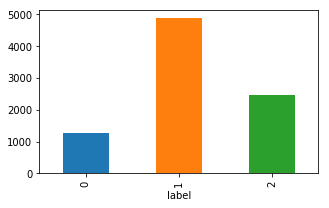

In [77]:
data.groupby('label')['label'].size().plot(kind='bar', figsize=(5, 3))

In [7]:
# the number of sample
len(data)

8625

### Split the dataset and Process the data

In [8]:
# split the dataset to train data and test data
X_train, X_test, Y_train, Y_test = train_test_split(data['tweet'],data['label'], test_size=0.1,random_state=1234)

In [9]:
# Processing the data, including labeling the label and digitizing the data
y_labels = list(Y_train.value_counts().index)
le = LabelEncoder()
le.fit(y_labels)
num_labels = len(y_labels)
y_train = to_categorical(Y_train.map(lambda x: le.transform([x])[0]), num_labels)
y_test = to_categorical(Y_test.map(lambda x: le.transform([x])[0]), num_labels)

# Word segmentation, build word-id dictionary
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['tweet'])
vocab = tokenizer.word_index

# Numericalize each word
X_train_word_ids = tokenizer.texts_to_sequences(X_train)
X_test_word_ids = tokenizer.texts_to_sequences(X_test)

# Padding each sequence with a length less than the maximum sequence length
x_train = pad_sequences(X_train_word_ids, maxlen=MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(X_test_word_ids, maxlen=MAX_SEQUENCE_LENGTH)
print(x_train.shape, x_test.shape)

(7762, 110) (863, 110)


### Load the glove word vecotr and vonvert it  
NOTE: If this code is run for the first time, you need to run the code in this cell to convert the format of the pre-training word vector.  
Twitter Pre-train Glove word vector: http://nlp.stanford.edu/data/glove.twitter.27B.zip  

In [72]:
# Load the glove word vector and use gensim to convert it to the word2vec word vector format
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

# input file
glove_file = './data/glove.twitter.27B.100d.txt'
# output file
tmp_file = "./data/twitter_glove_to_word2vec.txt"

# call glove2word2vec script
# default way (through CLI): python -m gensim.scripts.glove2word2vec --input <glove_file> --output <w2v_file>

# Start converting
glove2word2vec(glove_file, tmp_file)

(1193514, 100)

In [12]:
# Load the converted word vector file
vector_model = KeyedVectors.load_word2vec_format(tmp_file)

### Get pretrained word vector for each word

In [13]:
# Get the index after each word tokenizer
word_index = tokenizer.word_index
# Get the size of num_words
num_words = min(MAX_NB_WORDS, len(word_index))

#print(num_words)
ss = 0
# initialization embedding matrix
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

# print(len(word_index.items()))
# Get the word vector for each word
for word, i in word_index.items():
        if word in vector_model.wv.vocab:
                ss += 1
                if i >= num_words:
                    break
                embedding_matrix[i] = vector_model.wv[word]
        else:
                # print(word)
                pass
#print(embedding_matrix.shape)

/home/lilian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  
/home/lilian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


## 2、Bulid models

### TextCNN  
Convolutional Neural Networks for Sentence Classification  
https://arxiv.org/abs/1408.5882    

In [14]:
# bulid a TextCNN model
def TextCNNModel(num_labels, num_words, embedding_matrix):
        # Model structure：word_embedding-Convolution pooling*3-concatenate-Fully connected
    
        # define embedding_layer
        embedding_layer = Embedding(num_words,
                                    EMBEDDING_DIM,
                                    weights=[embedding_matrix],
                                    input_length=MAX_SEQUENCE_LENGTH,
                                    trainable=True)

        print('Training model.')
        sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
        embedded_sequences = embedding_layer(sequence_input)
        
        # Convolution pooling*3
        # The word window size is 3, 4, 5
        cnn1 = Convolution1D(256, 3, padding='same', strides=1, activation='relu')(embedded_sequences)
        cnn1 = MaxPooling1D(pool_size=int(cnn1.shape[1]))(cnn1)
        cnn2 = Convolution1D(256, 4, padding='same', strides=1, activation='relu')(embedded_sequences)
        cnn2 = MaxPooling1D(pool_size=int(cnn2.shape[1]))(cnn2)
        cnn3 = Convolution1D(256, 5, padding='same', strides=1, activation='relu')(embedded_sequences)
        cnn3 = MaxPooling1D(pool_size=int(cnn3.shape[1]))(cnn3)
        
        # concatenate
        cnn = concatenate([cnn1, cnn2, cnn3], axis=-1)
        
        # Flatten
        flat = Flatten()(cnn)
        
        # full concatenate
        preds = (Dense(num_labels, activation='softmax'))(flat)

        model = Model(sequence_input, preds)
        # model summary
        # model.summary()

        # model compile
        model.compile(loss='categorical_crossentropy',
                      optimizer='adam',
                      metrics=['acc'])

        return model

### BiGRU

In [15]:
# bulid a BiGRU model
def BiGRUModel(num_labels, num_words, embedding_matrix):
         # Model structure：word_embedding-Dropout-BiGRU-BiGRU-Dropout-Fully connected-Dropout-Fully connected-Dropout-Fully connected
    
        # define embedding_layer
    
        embedding_layer = Embedding(num_words,
                                    EMBEDDING_DIM,
                                    weights=[embedding_matrix],
                                    input_length=MAX_SEQUENCE_LENGTH,
                                    trainable=False)

        print('Training model.')
        sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
        embedded_sequences = embedding_layer(sequence_input)
        x = Dropout(0.5)(embedded_sequences)
        x = Bidirectional(GRU(256, activation='relu', return_sequences=True))(x)
        x = Bidirectional(GRU(128, activation='relu'))(x)
        x = Dropout(0.2)(x)
        x = Dense(128, activation='relu')(x)
        x = Dropout(0.2)(x)
        x = Dense(64, activation='relu')(x)
        x = Dropout(0.2)(x)
        preds = Dense(num_labels, activation='softmax')(x)

        model = Model(sequence_input, preds)
        # model summary
        # model.summary()

        # model compile
        model.compile(loss='categorical_crossentropy',
                      optimizer='adam',
                      metrics=['acc'])

        return model

### DPCNN  
Deep Pyramid Convolutional Neural Networks for Text Categorization(DPCNN)    
http://www.aclweb.org/anthology/P17-1052  

In [16]:
# bulid a DPCNN model
def DPCNNModel(num_labels, num_words, embedding_matrix):
        embedding_layer = Embedding(num_words,
                                    EMBEDDING_DIM,
                                    weights=[embedding_matrix],
                                    input_length=MAX_SEQUENCE_LENGTH,
                                    trainable=False)

        print('Training model.')
        sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
        embedded_sequences = embedding_layer(sequence_input)

        emb_comment = SpatialDropout1D(spatial_dropout)(embedded_sequences)

        block1 = Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='linear')(emb_comment)
        block1 = BatchNormalization()(block1)
        block1 = PReLU()(block1)
        block1 = Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='linear')(block1)
        block1 = BatchNormalization()(block1)
        block1 = PReLU()(block1)

        # we pass embedded comment through conv1d with filter size 1 because it needs to have the same shape as block output
        # if you choose filter_nr = embed_size (300 in this case) you don't have to do this part and can add emb_comment directly to block1_output
        resize_emb = Conv1D(filter_nr, kernel_size=1, padding='same', activation='linear')(emb_comment)
        resize_emb = PReLU()(resize_emb)

        block1_output = add([block1, resize_emb])
        block1_output = MaxPooling1D(pool_size=max_pool_size, strides=max_pool_strides)(block1_output)

        block2 = Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='linear')(block1_output)
        block2 = BatchNormalization()(block2)
        block2 = PReLU()(block2)
        block2 = Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='linear')(block2)
        block2 = BatchNormalization()(block2)
        block2 = PReLU()(block2)

        block2_output = add([block2, block1_output])
        block2_output = MaxPooling1D(pool_size=max_pool_size, strides=max_pool_strides)(block2_output)

        block3 = Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='linear')(block2_output)
        block3 = BatchNormalization()(block3)
        block3 = PReLU()(block3)
        block3 = Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='linear')(block3)
        block3 = BatchNormalization()(block3)
        block3 = PReLU()(block3)

        block3_output = add([block3, block2_output])
        block3_output = MaxPooling1D(pool_size=max_pool_size, strides=max_pool_strides)(block3_output)

        block4 = Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='linear')(block3_output)
        block4 = BatchNormalization()(block4)
        block4 = PReLU()(block4)
        block4 = Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='linear')(block4)
        block4 = BatchNormalization()(block4)
        block4 = PReLU()(block4)

        output = add([block4, block3_output])
        output = GlobalMaxPooling1D()(output)
        output = Dense(dense_nr, activation='linear')(output)
        output = BatchNormalization()(output)
        output = PReLU()(output)
        output = Dropout(dense_dropout)(output)
        preds = Dense(num_labels, activation='softmax')(output)

        model = Model(sequence_input, preds)
        #model.summary()

        model.compile(loss='categorical_crossentropy',
                      optimizer='adam',
                      metrics=['acc'])

        return model

## 3、cross validation and get results

In [17]:
# cross validation
def cross_validation(model_name):
        folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=2018).split(x_train, Y_train)
        #  Initialize two matrices to store the results of each cross-validation
        test_pred = np.zeros((x_test.shape[0], num_labels))
        test_pred_cv = np.zeros((5, x_test.shape[0], num_labels))

        for ii, (idx_train, idx_val) in enumerate(folds):
                print('*********************************************************************************************************************')
                print('Fold',ii)
                X_train_cv = x_train[idx_train]
                X_valid_cv = x_train[idx_val]
                y_train_cv = y_train[idx_train]
                y_valid_cv = y_train[idx_val]

                if model_name == 'TextCNN':
                        model = TextCNNModel(num_labels, num_words, embedding_matrix)
                elif model_name == 'DPCNN':
                        model = DPCNNModel(num_labels, num_words, embedding_matrix)
                elif model_name == 'BiGRU':
                        model = BiGRUModel(num_labels, num_words, embedding_matrix)
                else:
                        print('Please enter the correct model name')
                early_stop = EarlyStopping(patience=2)
                check_point = ModelCheckpoint('Fold_'+str(ii)+'_'+'_model_o.hdf5', monitor="val_acc", mode="max", save_best_only=True, verbose=1)

                history = model.fit(X_train_cv, y_train_cv, batch_size=128, epochs=100, verbose=1, class_weight='auto',validation_data=(X_valid_cv, y_valid_cv),
                                    callbacks=[early_stop, check_point])

                preds = model.predict(x_test)
                test_pred_cv[ii, :] = preds

        # Average of cross validation results
        test_pred[:] = test_pred_cv.mean(axis=0)
        #  Get the forecast category for each sample
        y_classes = test_pred[:].argmax(axis=-1)
        return test_pred[:],y_classes

## 4、Get Precision score、Recall score and ROC 

In [73]:
# Calculation accuracy and recall rate
def Precision_Recall(Y_test, y_classes):
    precision = round(precision_score(Y_test, y_classes, average='macro'),3)
    recall = round(recall_score(Y_test,y_classes,average='macro'),3)
    return precision,recall

In [19]:
# compute ROC and AUC
def ROC_and_AUC(Y_test,y_scores):
        # Binary the true label of the test sample
        Y_test = label_binarize(Y_test, classes=[0, 1, 2])
        
        # Set the n_classes parameter, which is the number of categories.
        n_classes = 3
        
        # Calculate ROC for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(Y_test[:, i],y_scores[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
    
        # Compute macro-average ROC curve and ROC area
        # First aggregate all false positive rates
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
        # Then interpolate all ROC curves at this points
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_classes):
            mean_tpr += interp(all_fpr, fpr[i], tpr[i])
        
        # Finally average it and compute AUC
        mean_tpr /= n_classes
        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
        n_classes
        
        # Plot all ROC curves
        lw=2
        plt.figure()
        plt.plot(fpr["macro"], tpr["macro"],
                 label='macro-average ROC curve (area = {0:0.2f})'
                       ''.format(roc_auc["macro"]),
                 color='navy', linestyle=':', linewidth=4)
        
        colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
        for i, color in zip(range(n_classes), colors):
            plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                     label='ROC curve of class {0} (area = {1:0.2f})'
                     ''.format(i, roc_auc[i]))
        
        plt.plot([0, 1], [0, 1], 'k--', lw=lw)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Results')
        plt.legend(loc="lower right")
        plt.show()

### 4.1TextCNN results

In [22]:
y_scores_TextCNN,y_classes_TextCNN = cross_validation(model_name='TextCNN')

*********************************************************************************************************************
Fold 0
Training model.
Train on 6208 samples, validate on 1554 samples
Epoch 1/100
6208/6208 [==============================] - 4s 696us/step - loss: 0.7989 - acc: 0.6434 - val_loss: 0.6754 - val_acc: 0.7027

Epoch 00001: val_acc improved from -inf to 0.70270, saving model to Fold_0__model_o.hdf5
Epoch 2/100
6208/6208 [==============================] - 1s 179us/step - loss: 0.4461 - acc: 0.8452 - val_loss: 0.6120 - val_acc: 0.7452

Epoch 00002: val_acc improved from 0.70270 to 0.74517, saving model to Fold_0__model_o.hdf5
Epoch 3/100
6208/6208 [==============================] - 1s 177us/step - loss: 0.2771 - acc: 0.9338 - val_loss: 0.5868 - val_acc: 0.7606

Epoch 00003: val_acc improved from 0.74517 to 0.76062, saving model to Fold_0__model_o.hdf5
Epoch 4/100
6208/6208 [==============================] - 1s 181us/step - loss: 0.1602 - acc: 0.9770 - val_loss: 0.5750 - val

In [74]:
# get precision & recall
precision_TextCNN,recall_TextCNN = Precision_Recall(Y_test, y_classes_TextCNN)
print('The TextCNN precision score is: ',precision_TextCNN)
print('The TextCNN recall score is: ',recall_TextCNN)

The TextCNN precision score is:  0.748
The TextCNN recall score is:  0.708


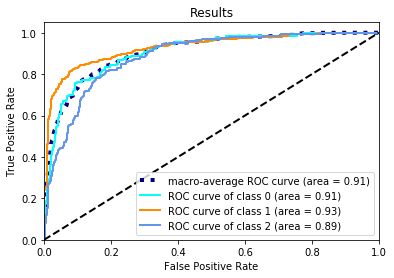

In [25]:
ROC_and_AUC(Y_test,y_scores_TextCNN)

### 4.2 DPCNN results

In [35]:
y_scores_DPCNN,y_classes_DPCNN = cross_validation(model_name='DPCNN')

*********************************************************************************************************************
Fold 0
Training model.
Train on 6208 samples, validate on 1554 samples
Epoch 1/100
6208/6208 [==============================] - 11s 2ms/step - loss: 1.1918 - acc: 0.4974 - val_loss: 0.8980 - val_acc: 0.5766

Epoch 00001: val_acc improved from -inf to 0.57658, saving model to Fold_0__model_o.hdf5
Epoch 2/100
6208/6208 [==============================] - 3s 459us/step - loss: 0.9782 - acc: 0.5720 - val_loss: 0.8995 - val_acc: 0.6171

Epoch 00002: val_acc improved from 0.57658 to 0.61712, saving model to Fold_0__model_o.hdf5
Epoch 3/100
6208/6208 [==============================] - 3s 461us/step - loss: 0.8814 - acc: 0.6041 - val_loss: 0.8417 - val_acc: 0.6358

Epoch 00003: val_acc improved from 0.61712 to 0.63578, saving model to Fold_0__model_o.hdf5
Epoch 4/100
6208/6208 [==============================] - 3s 444us/step - loss: 0.8140 - acc: 0.6334 - val_loss: 0.8360 - val_

Epoch 7/100
6211/6211 [==============================] - 3s 483us/step - loss: 0.6726 - acc: 0.7120 - val_loss: 0.7648 - val_acc: 0.6802

Epoch 00007: val_acc improved from 0.67956 to 0.68021, saving model to Fold_3__model_o.hdf5
Epoch 8/100
6211/6211 [==============================] - 3s 466us/step - loss: 0.6390 - acc: 0.7331 - val_loss: 0.7115 - val_acc: 0.6989

Epoch 00008: val_acc improved from 0.68021 to 0.69890, saving model to Fold_3__model_o.hdf5
Epoch 9/100
6211/6211 [==============================] - 3s 453us/step - loss: 0.6002 - acc: 0.7467 - val_loss: 0.6807 - val_acc: 0.7086

Epoch 00009: val_acc improved from 0.69890 to 0.70858, saving model to Fold_3__model_o.hdf5
Epoch 10/100
6211/6211 [==============================] - 3s 456us/step - loss: 0.5724 - acc: 0.7572 - val_loss: 0.6948 - val_acc: 0.7157

Epoch 00010: val_acc improved from 0.70858 to 0.71567, saving model to Fold_3__model_o.hdf5
Epoch 11/100
6211/6211 [==============================] - 3s 474us/step - loss:

In [75]:
# get precision & recall
precision_DPCNN,recall_DPCNN= Precision_Recall(Y_test, y_classes_DPCNN)
print('The DPCNN precision score is: ',precision_DPCNN)
print('The DPCNN recall score is: ',recall_DPCNN)

The DPCNN precision score is:  0.725
The DPCNN recall score is:  0.598


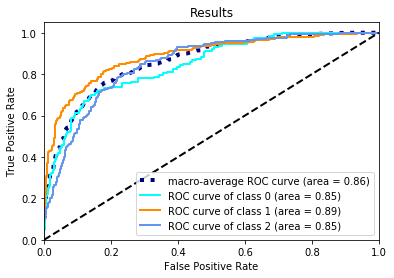

In [37]:
# plot the ROC  & AUC 
ROC_and_AUC(Y_test,y_scores_DPCNN)

### 4.3 BiGRUCNN results

In [44]:
y_scores_BiGRU,y_classes_BiGRU = cross_validation(model_name='BiGRU')

*********************************************************************************************************************
Fold 0
Training model.
Train on 6208 samples, validate on 1554 samples
Epoch 1/100
6208/6208 [==============================] - 81s 13ms/step - loss: 0.9312 - acc: 0.5665 - val_loss: 0.8254 - val_acc: 0.6351

Epoch 00001: val_acc improved from -inf to 0.63514, saving model to Fold_0__model_o.hdf5
Epoch 2/100
6208/6208 [==============================] - 58s 9ms/step - loss: 0.8093 - acc: 0.6316 - val_loss: 0.7531 - val_acc: 0.6551

Epoch 00002: val_acc improved from 0.63514 to 0.65508, saving model to Fold_0__model_o.hdf5
Epoch 3/100
6208/6208 [==============================] - 58s 9ms/step - loss: 0.7719 - acc: 0.6534 - val_loss: 0.7191 - val_acc: 0.6924

Epoch 00003: val_acc improved from 0.65508 to 0.69241, saving model to Fold_0__model_o.hdf5
Epoch 4/100
6208/6208 [==============================] - 59s 10ms/step - loss: 0.7303 - acc: 0.6819 - val_loss: 0.6832 - val_a


Epoch 00003: val_acc improved from 0.67869 to 0.71024, saving model to Fold_2__model_o.hdf5
Epoch 4/100
6209/6209 [==============================] - 55s 9ms/step - loss: 0.7397 - acc: 0.6792 - val_loss: 0.6735 - val_acc: 0.7090

Epoch 00004: val_acc did not improve from 0.71024
Epoch 5/100
6209/6209 [==============================] - 54s 9ms/step - loss: 0.6935 - acc: 0.7014 - val_loss: 0.6392 - val_acc: 0.7386

Epoch 00005: val_acc improved from 0.71024 to 0.73857, saving model to Fold_2__model_o.hdf5
Epoch 6/100
6209/6209 [==============================] - 56s 9ms/step - loss: 0.6895 - acc: 0.7066 - val_loss: 0.6272 - val_acc: 0.7514

Epoch 00006: val_acc improved from 0.73857 to 0.75145, saving model to Fold_2__model_o.hdf5
Epoch 7/100
6209/6209 [==============================] - 55s 9ms/step - loss: 0.6686 - acc: 0.7219 - val_loss: 0.6083 - val_acc: 0.7469

Epoch 00007: val_acc did not improve from 0.75145
Epoch 8/100
6209/6209 [==============================] - 55s 9ms/step - los


Epoch 00008: val_acc improved from 0.74790 to 0.75693, saving model to Fold_4__model_o.hdf5
Epoch 9/100
6211/6211 [==============================] - 54s 9ms/step - loss: 0.6222 - acc: 0.7429 - val_loss: 0.6129 - val_acc: 0.7602

Epoch 00009: val_acc improved from 0.75693 to 0.76015, saving model to Fold_4__model_o.hdf5
Epoch 10/100
6211/6211 [==============================] - 54s 9ms/step - loss: 0.5957 - acc: 0.7572 - val_loss: 0.5847 - val_acc: 0.7750

Epoch 00010: val_acc improved from 0.76015 to 0.77498, saving model to Fold_4__model_o.hdf5
Epoch 11/100
6211/6211 [==============================] - 55s 9ms/step - loss: 0.5670 - acc: 0.7736 - val_loss: 0.5835 - val_acc: 0.7769

Epoch 00011: val_acc improved from 0.77498 to 0.77692, saving model to Fold_4__model_o.hdf5
Epoch 12/100
6211/6211 [==============================] - 54s 9ms/step - loss: 0.5629 - acc: 0.7685 - val_loss: 0.5794 - val_acc: 0.7776

Epoch 00012: val_acc improved from 0.77692 to 0.77756, saving model to Fold_4__m

In [76]:
# get precision & recall
precision_BiGRU,recall_BiGRU= Precision_Recall(Y_test, y_classes_BiGRU)
print('The DPCNN precision score is: ',precision_BiGRU)
print('The DPCNN recall score is: ',recall_BiGRU)

The DPCNN precision score is:  0.782
The DPCNN recall score is:  0.707


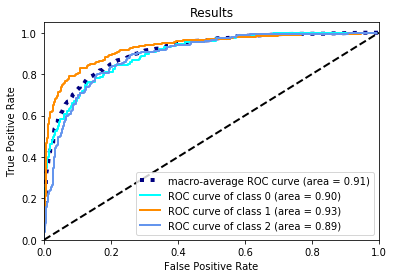

In [46]:
# plot the ROC  & AUC 
ROC_and_AUC(Y_test,y_scores_BiGRU)

### Visualize results

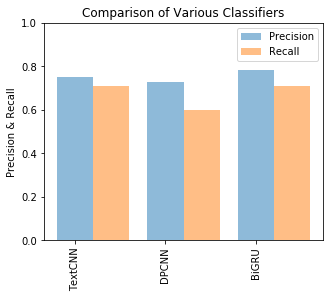

In [71]:
classifiers = ['TextCNN',  'DPCNN','BiGRU']
Precision = [0.748,0.725,0.782]
Recall = [0.708,0.598,0.707]
x = list(range(len(Precision)))
total_width, n = 0.8, 2
plt.figure(2, [5,4])
plt.bar(x, Precision, width=width,align='center', label='Precision',alpha=0.5)
for i in range(len(x)):
    x[i] += width
plt.bar(x, Recall,width=width, align='center',label='Recall', alpha=0.5)
plt.xticks(range(len(classifiers)), classifiers, rotation=90)
plt.ylabel('Precision & Recall')
plt.title('Comparison of Various Classifiers')
plt.ylim([0, 1])
plt.legend()
plt.show()

### Some ways to improve performance

1、可以增加数据集，现有数据集过小（PS:若原始数据集只有2000条，那么可以采用数据增强的方法，如同义词替换和回译(TTA)）  
2、可以从模型方面入手，如调整模型的参数：embedding维度、dropout的大小等    
3、使用更加复杂的模型。如BERT  
4、若是自己根据现有预料训练词向量，则在数据量小的时候可以采用预训练的词向量来提升效果(PS:这点可以忽略，本次实验采用的就是预训练的词向量)  